### **LEITURA E FORMATAÇÃO DO ARQUIVO**

In [140]:
import pandas as pd
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CSV_Reader").getOrCreate()
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import udf 
from pyspark.sql.types import StringType 
import os


In [ ]:
# Conexão JDBC 


POSTGRES_JDBC_DRIVER_PATH = "C:\\spark\\spark-3.4.1\\jars\\postgresql-42.7.8.jar"


spark = SparkSession.builder \
    .appName("PostgreSQLConnection_Tech3") \
    .config("spark.jars", POSTGRES_JDBC_DRIVER_PATH) \
    .getOrCreate()

print("SparkSession iniciada e driver JDBC 'postgresql-42.7.8.jar' carregado com sucesso.")


print(f"Drivers carregados: {spark.sparkContext.getConf().get('spark.jars')}")

jdbc_url = "jdbc:postgresql://localhost:5432/Tech3" 
jdbc_user = "postgres" 
jdbc_password = "alef"
MODE = "overwrite" 

connection_properties = {
    "user": jdbc_user,
    "password": jdbc_password,

    "driver": "org.postgresql.Driver" 
}

print("Propriedades de conexão definidas.")

SparkSession iniciada e driver JDBC 'postgresql-42.7.8.jar' carregado com sucesso.
Drivers carregados: C:\spark\spark-3.4.1\jars\postgresql-42.7.8.jar
Propriedades de conexão definidas.


In [142]:
csv_path_julho = "PNAD_COVID_072020\PNAD_COVID_072020.csv"

df_julho = spark.read.csv(csv_path_julho, sep = ",", header=True, inferSchema=True)

In [143]:
csv_path_setembro = "PNAD_COVID_092020\PNAD_COVID_092020.csv"

df_setembro = spark.read.csv(csv_path_setembro, sep = ",", header=True, inferSchema=True)

In [144]:
csv_path_novembro = "PNAD_COVID_112020\PNAD_COVID_112020.csv"

df_novembro = spark.read.csv(csv_path_novembro, sep = ",", header=True, inferSchema=True)

In [145]:
# Seleciona apenas as colunas desejadas

colunas_desejadas = [
"A001","UPA","V1008","V1013","A002","A003","A006","B0015","B0011","B00111","B0012","B0014","B0018","B0019","B009F","B009D","B009B","B011","C001","C007C","C007E","C012","V1022","UF"]

df_novembro = df_novembro.select(colunas_desejadas)
df_setembro = df_setembro.select(colunas_desejadas)
df_julho = df_julho.select(colunas_desejadas)

In [146]:
#Junta os três meses em um unico DataFrame
df_completo = df_novembro.union(df_setembro).union(df_julho)



In [147]:

# Renomeia as colunas (exemplo: ajuste conforme necessário)
df_renamed = df_completo.withColumnRenamed("UF", "PESS_UF"
).withColumnRenamed("V1008", "CTRL_NUM_DOMICILIO"
).withColumnRenamed("V1013", "CTRL_MES"
).withColumnRenamed("V1022", "PESS_SIT_DOMICILIO"
).withColumnRenamed("UPA", "CTRL_UPA"
).withColumnRenamed("A001", "CTRL_NUM_MORADOR"
).withColumnRenamed("A002", "PESS_IDADE_MORADOR"
).withColumnRenamed("A003", "PESS_SEXO_MORADOR"
).withColumnRenamed("A006", "PESS_ESTUDA"
).withColumnRenamed("B0015", "SINT_DOR_CABECA"   
).withColumnRenamed("B0011", "SINT_FEBRE"
).withColumnRenamed("B0012", "SINT_TOSSE"
).withColumnRenamed("B0014", "SINT_DIF_RESPIRAR"
).withColumnRenamed("B0018", "SINT_CORIZA"
).withColumnRenamed("B0019", "SINT_FADIGA"
).withColumnRenamed("B00111", "SINT_PERDA_OLFATO"
).withColumnRenamed("B009F", "TESTE_SANGUE_VEIA"
).withColumnRenamed("B009D", "TESTE_SANGUE_DEDO"
).withColumnRenamed("B009B", "TESTE_SWAB"			   
).withColumnRenamed("B011", "DISTANC_SOCIAL"
).withColumnRenamed("C001", "TRAB_SP_TRABALHOU"
).withColumnRenamed("C007C", "TRAB_TIPO_TRABALHO"
).withColumnRenamed("C007E", "TRAB_QUANT_EMPREGADOS"
).withColumnRenamed("C012", "TRAB_PRESENCIAL"
                    )

df_renamed = df_renamed.withColumn(
    "CTRL_ID",
    concat(
        lpad(df_renamed["CTRL_UPA"], 15, "0"),
        lpad(df_renamed["CTRL_NUM_DOMICILIO"], 2, "0"),
        lpad(df_renamed["CTRL_NUM_MORADOR"], 2, "0")
    )
)


# Exibe o DataFrame renomeado
df_renamed.show()

+----------------+---------+------------------+--------+------------------+-----------------+-----------+---------------+----------+-----------------+----------+-----------------+-----------+-----------+-----------------+-----------------+----------+--------------+-----------------+------------------+---------------------+---------------+------------------+-------+-------------------+
|CTRL_NUM_MORADOR| CTRL_UPA|CTRL_NUM_DOMICILIO|CTRL_MES|PESS_IDADE_MORADOR|PESS_SEXO_MORADOR|PESS_ESTUDA|SINT_DOR_CABECA|SINT_FEBRE|SINT_PERDA_OLFATO|SINT_TOSSE|SINT_DIF_RESPIRAR|SINT_CORIZA|SINT_FADIGA|TESTE_SANGUE_VEIA|TESTE_SANGUE_DEDO|TESTE_SWAB|DISTANC_SOCIAL|TRAB_SP_TRABALHOU|TRAB_TIPO_TRABALHO|TRAB_QUANT_EMPREGADOS|TRAB_PRESENCIAL|PESS_SIT_DOMICILIO|PESS_UF|            CTRL_ID|
+----------------+---------+------------------+--------+------------------+-----------------+-----------+---------------+----------+-----------------+----------+-----------------+-----------+-----------+-----------------+---

### **DICIONÁRIOS DE DOMINIO DOS DADOS**

In [148]:
csv_path_dict = "Dicionario_PNAD_COVID_112020_20220621.csv"

# pula as 4 primeiras linhas e usa a 5ª como cabeçalho
df_dict = pd.read_csv(
    csv_path_dict, 
    sep=";", 
    encoding="latin1", 
    skiprows=4,   # pula as 4 primeiras
    header=0      # a próxima linha (linha 5) vira o cabeçalho
)

# Indices das linhas de comentários do dicionário 
indices_to_remove = [91, 169, 343, 569, 598, 614]

df_dict_filtered = df_dict.drop(indices_to_remove)

# Usar ffill para preencher os valores vazios com o valor anterior
df_dict_filtered['Ano'] = df_dict_filtered['Ano'].ffill()
df_dict_filtered['Ano de referência'] = df_dict_filtered['Ano de referência'].ffill()

# Criando DF spark
df_dict_filtered = spark.createDataFrame(df_dict_filtered)


#Ronomeando colunaaa
df_dict_rename = df_dict_filtered.withColumnRenamed("Ano", "COD_VAR"
).withColumnRenamed("Ano de referência", "DESCR_VAR"
).withColumnRenamed("Unnamed: 4", "COD_TIPO"
).withColumnRenamed("Unnamed: 5", "DESCR_TIPO")

df_dict_rename = df_dict_rename.select(
    "COD_VAR", "DESCR_VAR","COD_TIPO","DESCR_TIPO"
)

#FILTRANDO APENAS COLUNAS DESEJADAS
df_filtro = df_dict_rename.filter(col("COD_VAR").isin(colunas_desejadas))

df_filtro.show()


+-------+--------------------+--------+-------------------+
|COD_VAR|           DESCR_VAR|COD_TIPO|         DESCR_TIPO|
+-------+--------------------+--------+-------------------+
|     UF|Unidade da Federação|      11|           Rondônia|
|     UF|Unidade da Federação|      12|               Acre|
|     UF|Unidade da Federação|      13|           Amazonas|
|     UF|Unidade da Federação|      14|            Roraima|
|     UF|Unidade da Federação|      15|               Pará|
|     UF|Unidade da Federação|      16|              Amapá|
|     UF|Unidade da Federação|      17|          Tocantins|
|     UF|Unidade da Federação|      21|           Maranhão|
|     UF|Unidade da Federação|      22|              Piauí|
|     UF|Unidade da Federação|      23|              Ceará|
|     UF|Unidade da Federação|      24|Rio Grande do Norte|
|     UF|Unidade da Federação|      25|            Paraíba|
|     UF|Unidade da Federação|      26|         Pernambuco|
|     UF|Unidade da Federação|      27| 

In [149]:
dic_pess_uf_df = (
    df_filtro
    .filter(col("COD_VAR") == "UF")
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "PESS_UF")
    .withColumnRenamed("DESCR_TIPO", "PESS_UF_DESC"))



dic_pess_sit_domicilio_df = (
    df_filtro
    .filter(col("COD_VAR") == "V1022")
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "PESS_SIT_DOMICILIO")
    .withColumnRenamed("DESCR_TIPO", "PESS_SIT_DOMICILIO_DESC"))


dic_pess_sexo_morador = (
    df_filtro
    .filter(col("COD_VAR") == "A003")
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "PESS_SEXO_MORADOR")
    .withColumnRenamed("DESCR_TIPO", "PESS_SEXO_MORADOR_DESC"))



dic_sintomas_df = (
    df_filtro
    .filter(col("COD_VAR")=='B0012')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "SINT_COD")
    .withColumnRenamed("DESCR_TIPO", "SINT_DESC"))

dic_estuda_df = (
    df_filtro
    .filter(col("COD_VAR")=='A006')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "ESTUDA_COD")
    .withColumnRenamed("DESCR_TIPO", "ESTUDA_DESC"))    

dic_resultado_teste_df = (
    df_filtro
    .filter(col("COD_VAR")=='B009B')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TESTE_COD")
    .withColumnRenamed("DESCR_TIPO", "TESTE_DESC"))    

dic_isolamento_social_df = (
    df_filtro
    .filter(col("COD_VAR")=='B011')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "ISO_COD")
    .withColumnRenamed("DESCR_TIPO", "ISO_DESC"))    

dic_trab_sp_trabalhou_df = (
    df_filtro
    .filter(col("COD_VAR")=='C001')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_SP_TRABALHOU_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_SP_TRABALHOU_DESC"))

dic_trab_tipo_trabalho_df = (
    df_filtro
    .filter(col("COD_VAR")=='C007C')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_TIPO_TRABALHO_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_TIPO_TRABALHO_DESC"))

dic_trab_qt_empregados_df = (
    df_filtro
    .filter(col("COD_VAR")=='C007E')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_QUANT_EMPREGADOS_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_QUANT_EMPREGADOS_DESC"))


dic_trab_ms_local_df = (
    df_filtro
    .filter(col("COD_VAR")=='C012')
    .select("COD_TIPO", "DESCR_TIPO")
    .withColumnRenamed("COD_TIPO", "TRAB_MESMO_LOCAL_COD")
    .withColumnRenamed("DESCR_TIPO", "TRAB_MESMO_LOCAL_DESC"))



### **SEPARAÇÃO DOS DADOS NAS TABELAS DISTINTAS**

In [150]:
colunas_dados_pess = ["CTRL_MES", "CTRL_ID", "PESS_UF", "PESS_SIT_DOMICILIO", "PESS_IDADE_MORADOR", "PESS_SEXO_MORADOR","PESS_ESTUDA"]

df_dados_pess = df_renamed.select(colunas_dados_pess)

colunas_dados_trab = ["CTRL_MES", "CTRL_ID", "TRAB_SP_TRABALHOU", "TRAB_TIPO_TRABALHO", "TRAB_QUANT_EMPREGADOS", "TRAB_PRESENCIAL"]

df_dados_trab = df_renamed.select(colunas_dados_trab)

colunas_dados_sint = ["CTRL_MES", "CTRL_ID",  "SINT_FEBRE", "SINT_TOSSE", "SINT_DOR_CABECA", "SINT_DIF_RESPIRAR", "SINT_CORIZA", "SINT_FADIGA", "SINT_PERDA_OLFATO"]

df_dados_sint = df_renamed.select(colunas_dados_sint)

colunas_dados_iso_social = ["CTRL_MES", "CTRL_ID", "DISTANC_SOCIAL"]

df_dados_iso_social = df_renamed.select(colunas_dados_iso_social)


colunas_dados_tst_covd = ["CTRL_MES", "CTRL_ID","TESTE_SWAB", "TESTE_SANGUE_DEDO", "TESTE_SANGUE_VEIA"]

df_dados_dados_tst_covd = df_renamed.select(colunas_dados_tst_covd)


In [151]:
df_dados_pess.printSchema()
df_dados_trab.printSchema()
df_dados_sint.printSchema()
df_dados_iso_social.printSchema()
df_dados_dados_tst_covd.printSchema()


root
 |-- CTRL_MES: integer (nullable = true)
 |-- CTRL_ID: string (nullable = true)
 |-- PESS_UF: integer (nullable = true)
 |-- PESS_SIT_DOMICILIO: integer (nullable = true)
 |-- PESS_IDADE_MORADOR: integer (nullable = true)
 |-- PESS_SEXO_MORADOR: integer (nullable = true)
 |-- PESS_ESTUDA: integer (nullable = true)

root
 |-- CTRL_MES: integer (nullable = true)
 |-- CTRL_ID: string (nullable = true)
 |-- TRAB_SP_TRABALHOU: integer (nullable = true)
 |-- TRAB_TIPO_TRABALHO: integer (nullable = true)
 |-- TRAB_QUANT_EMPREGADOS: integer (nullable = true)
 |-- TRAB_PRESENCIAL: integer (nullable = true)

root
 |-- CTRL_MES: integer (nullable = true)
 |-- CTRL_ID: string (nullable = true)
 |-- SINT_FEBRE: integer (nullable = true)
 |-- SINT_TOSSE: integer (nullable = true)
 |-- SINT_DOR_CABECA: integer (nullable = true)
 |-- SINT_DIF_RESPIRAR: integer (nullable = true)
 |-- SINT_CORIZA: integer (nullable = true)
 |-- SINT_FADIGA: integer (nullable = true)
 |-- SINT_PERDA_OLFATO: integer 

In [152]:
# Tabela de Dados Pessoais
df_dados_pess.createOrReplaceTempView("dados_pessoais")

# Tabela de Dados de Trabalho
df_dados_trab.createOrReplaceTempView("dados_trabalho")

# Tabela de Dados de Sintomas
df_dados_sint.createOrReplaceTempView("dados_sintomas")

# Tabela de Dados de Isolamento Social
df_dados_iso_social.createOrReplaceTempView("dados_isolamento_social")

# Tabela de Dados de Teste COVID
df_dados_dados_tst_covd.createOrReplaceTempView("dados_teste_covid")

# Tabela Dicionário de Unidades Federativas (UF)
dic_pess_uf_df.createOrReplaceTempView("dic_uf")

# Tabela Dicionário de Situação do Domicílio
dic_pess_sit_domicilio_df.createOrReplaceTempView("dic_sit_domicilio")

# Tabela Dicionário de Sexo do Morador
dic_pess_sexo_morador.createOrReplaceTempView("dic_sexo_morador")

# Tabela Dicionário de Sintomas
dic_sintomas_df.createOrReplaceTempView("dic_sintomas")

# Tabela Dicionário de Estuda
dic_estuda_df.createOrReplaceTempView("dic_estuda")

# Tabela Dicionário de Resultado de Teste
dic_resultado_teste_df.createOrReplaceTempView("dic_resultado_teste")

# Tabela Dicionário de Isolamento Social
dic_isolamento_social_df.createOrReplaceTempView("dic_isolamento_social")

# Tabela Dicionário de Trabalhou na Semana Passada (SP)
dic_trab_sp_trabalhou_df.createOrReplaceTempView("dic_trab_sp_trabalhou")

# Tabela Dicionário de Tipo de Trabalho
dic_trab_tipo_trabalho_df.createOrReplaceTempView("dic_trab_tipo_trabalho")

# Tabela Dicionário de Quantidade de Empregados
dic_trab_qt_empregados_df.createOrReplaceTempView("dic_trab_qt_empregados")

# Tabela Dicionário de Mesma Localidade (Trabalho)
dic_trab_ms_local_df.createOrReplaceTempView("dic_trab_mesmo_local")


### **CRIAÇÃO DO BANCO DE DADOS**

In [153]:
def inserir_tabela_postgres(df, nome_tabela):
    """Insere um DataFrame (df) em uma tabela (nome_tabela) no PostgreSQL."""
    print(f"   -> Tentando inserir tabela: '{nome_tabela}'...")
    try:
        df.write.jdbc(
            url=jdbc_url,
            table=nome_tabela,
            mode=MODE,
            properties=connection_properties
        )
        print(f"✅ Tabela '{nome_tabela}' inserida com sucesso (Modo: {MODE}).")
    except Exception as e:
        # A exceção Py4JJavaError será capturada aqui
        print(f"❌ ERRO GRAVE ao inserir a tabela '{nome_tabela}'. Verifique o driver JDBC e a conexão do DB.")
        print(f"Detalhes do Erro: {e}")





print("\n--- INICIANDO INSERÇÃO DOS DADOS PRINCIPAIS ---")
for nome_tabela, df in dfs_dados.items():
    inserir_tabela_postgres(df, nome_tabela)

print("\n--- INICIANDO INSERÇÃO DOS DICIONÁRIOS (DICs) ---")
for nome_tabela, df in dfs_dics.items():
    inserir_tabela_postgres(df, nome_tabela)


--- INICIANDO INSERÇÃO DOS DADOS PRINCIPAIS ---
   -> Tentando inserir tabela: 'dados_pessoais'...
✅ Tabela 'dados_pessoais' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_trabalho'...
✅ Tabela 'dados_trabalho' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_sintomas'...
✅ Tabela 'dados_sintomas' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_isolamento_social'...
✅ Tabela 'dados_isolamento_social' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dados_teste_covid'...
✅ Tabela 'dados_teste_covid' inserida com sucesso (Modo: overwrite).

--- INICIANDO INSERÇÃO DOS DICIONÁRIOS (DICs) ---
   -> Tentando inserir tabela: 'dic_uf'...
✅ Tabela 'dic_uf' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dic_sit_domicilio'...
✅ Tabela 'dic_sit_domicilio' inserida com sucesso (Modo: overwrite).
   -> Tentando inserir tabela: 'dic_sexo_morador'...
✅ Tabela 'dic_

### **ANALISES EXPLORATORIAS**


### 1 - Estados com mais testes positivos

Resultado da Análise 1:
+--------------+---------------+
|        Estado|Total_Positivos|
+--------------+---------------+
|      Maranhão|           5220|
|Rio de Janeiro|           5165|
|     São Paulo|           5051|
|         Goiás|           4051|
|         Ceará|           3610|
|Santa Catarina|           3592|
|      Amazonas|           3345|
|Espírito Santo|           3311|
|  Minas Gerais|           3202|
|          Pará|           3030|
+--------------+---------------+



C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\1770736014.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total_Positivos", y="Estado", data=pandas_df, orient='h', palette="viridis")


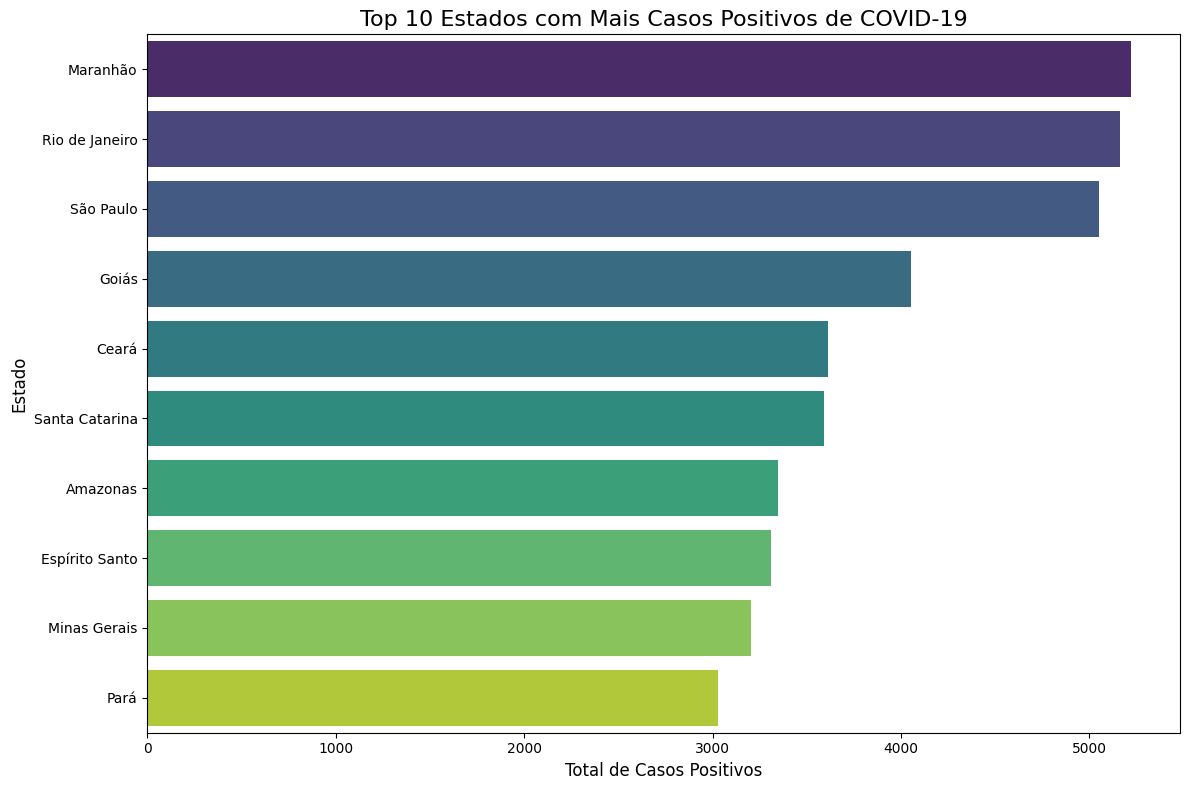

In [154]:
# Análise 1: Top 10 estados com mais casos positivos
query1 = """
    SELECT
        du.PESS_UF_DESC AS Estado,
        COUNT(dp.CTRL_ID) AS Total_Positivos
    FROM dados_pessoais dp
    JOIN dados_teste_covid dtc ON dp.CTRL_ID = dtc.CTRL_ID
    JOIN dic_uf du ON dp.PESS_UF = du.PESS_UF
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY
        du.PESS_UF_DESC
    ORDER BY
        Total_Positivos DESC
    LIMIT 10
"""
analise1_df = spark.sql(query1)
print("Resultado da Análise 1:")
analise1_df.show()

pandas_df = analise1_df.toPandas()


plt.figure(figsize=(12, 8))
sns.barplot(x="Total_Positivos", y="Estado", data=pandas_df, orient='h', palette="viridis")


plt.title('Top 10 Estados com Mais Casos Positivos de COVID-19', fontsize=16)
plt.xlabel('Total de Casos Positivos', fontsize=12)
plt.ylabel('Estado', fontsize=12)


plt.tight_layout()


plt.savefig('grafico_top_10_estados.png', dpi=300)


plt.show()




### 2 - Positivos por área (Urbano/Rural)

Resultado da Análise 2:
+------+---------------+
|  Area|Total_Positivos|
+------+---------------+
|Urbana|          64856|
| Rural|           9478|
+------+---------------+



C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\4155373690.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Area', y='Total_Positivos', data=pandas_df_2, palette='plasma')


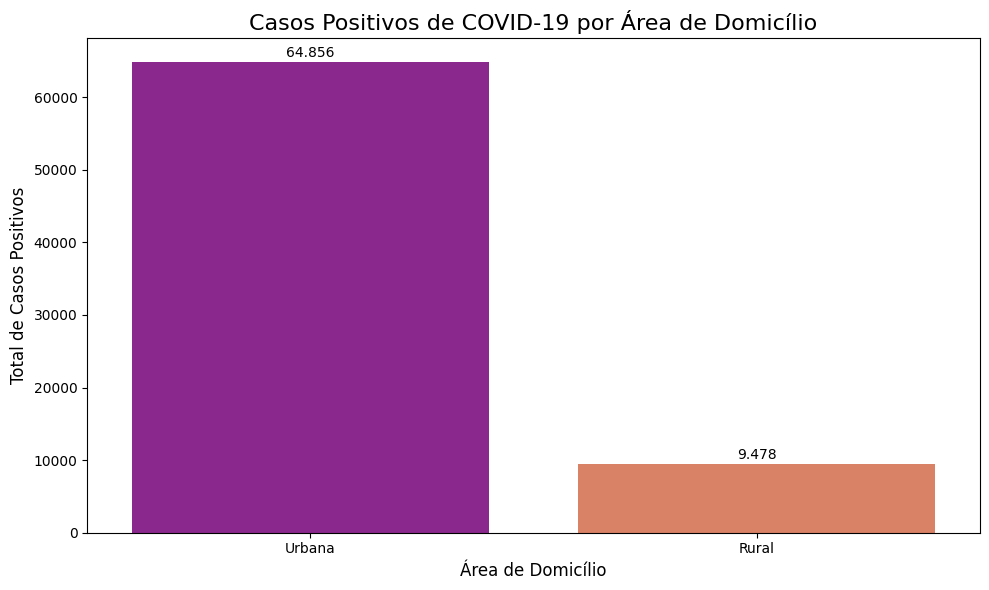

In [155]:
# Análise 2: Casos positivos por área de domicílio
query2 = """
    SELECT
        dsd.PESS_SIT_DOMICILIO_DESC AS Area,
        COUNT(dp.CTRL_ID) AS Total_Positivos
    FROM dados_pessoais dp
    JOIN dados_teste_covid dtc ON dp.CTRL_ID = dtc.CTRL_ID
    JOIN dic_sit_domicilio dsd ON dp.PESS_SIT_DOMICILIO = dsd.PESS_SIT_DOMICILIO
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY
        dsd.PESS_SIT_DOMICILIO_DESC
"""
analise2_df = spark.sql(query2)
print("Resultado da Análise 2:")
analise2_df.show()


pandas_df_2 = analise2_df.toPandas()


pandas_df_2 = pandas_df_2.sort_values(by='Total_Positivos', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Area', y='Total_Positivos', data=pandas_df_2, palette='plasma')


plt.title('Casos Positivos de COVID-19 por Área de Domicílio', fontsize=16)
plt.xlabel('Área de Domicílio', fontsize=12)
plt.ylabel('Total de Casos Positivos', fontsize=12)
plt.xticks(rotation=0) 


for index, row in pandas_df_2.iterrows():
    plt.text(index, row['Total_Positivos'] + (pandas_df_2['Total_Positivos'].max() * 0.01),
             f"{row['Total_Positivos']:,}".replace(',', '.'),
             color='black', ha="center")


plt.tight_layout()


plt.savefig('grafico_casos_por_area.png', dpi=300)

# 7. Exibir o gráfico
plt.show()

### 3 - Faixas etárias

Resultado da Análise 3:
+------------+---------------+
|Faixa_Etaria|Total_Positivos|
+------------+---------------+
|   0-17 Anos|           6065|
|  18-29 Anos|          13101|
|  30-49 Anos|          32384|
|  50-64 Anos|          15912|
|    65+ Anos|           6872|
+------------+---------------+



C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\210241859.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Faixa_Etaria', y='Total_Positivos', data=pandas_df_3, palette='mako')


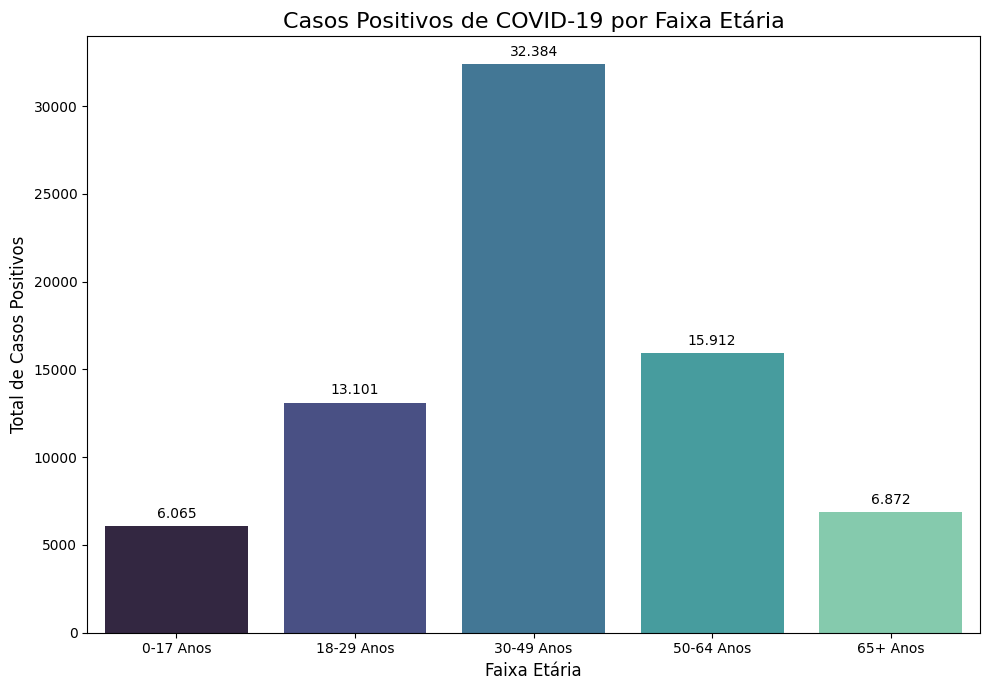

In [156]:
# Análise 3: Casos positivos por faixa etária
query3 = """
    SELECT
        CASE
            WHEN PESS_IDADE_MORADOR <= 17 THEN '0-17 Anos'
            WHEN PESS_IDADE_MORADOR BETWEEN 18 AND 29 THEN '18-29 Anos'
            WHEN PESS_IDADE_MORADOR BETWEEN 30 AND 49 THEN '30-49 Anos'
            WHEN PESS_IDADE_MORADOR BETWEEN 50 AND 64 THEN '50-64 Anos'
            ELSE '65+ Anos'
        END AS Faixa_Etaria,
        COUNT(dp.CTRL_ID) AS Total_Positivos
    FROM dados_pessoais dp
    JOIN dados_teste_covid dtc ON dp.CTRL_ID = dtc.CTRL_ID
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY
        Faixa_Etaria
    ORDER BY
        Faixa_Etaria
"""
analise3_df = spark.sql(query3)
print("Resultado da Análise 3:")
analise3_df.show()




pandas_df_3 = analise3_df.toPandas()


plt.figure(figsize=(10, 7))
ax = sns.barplot(x='Faixa_Etaria', y='Total_Positivos', data=pandas_df_3, palette='mako')


plt.title('Casos Positivos de COVID-19 por Faixa Etária', fontsize=16)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Total de Casos Positivos', fontsize=12)


for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}".replace(',', '.'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')


plt.tight_layout()


plt.savefig('grafico_casos_por_faixa_etaria.png', dpi=300)

plt.show()



### 4 - Homens vs Mulheres Infectados

Resultado da Análise 4:
+------+---------------+
|  Sexo|Total_Positivos|
+------+---------------+
| Homem|          33270|
|Mulher|          41064|
+------+---------------+



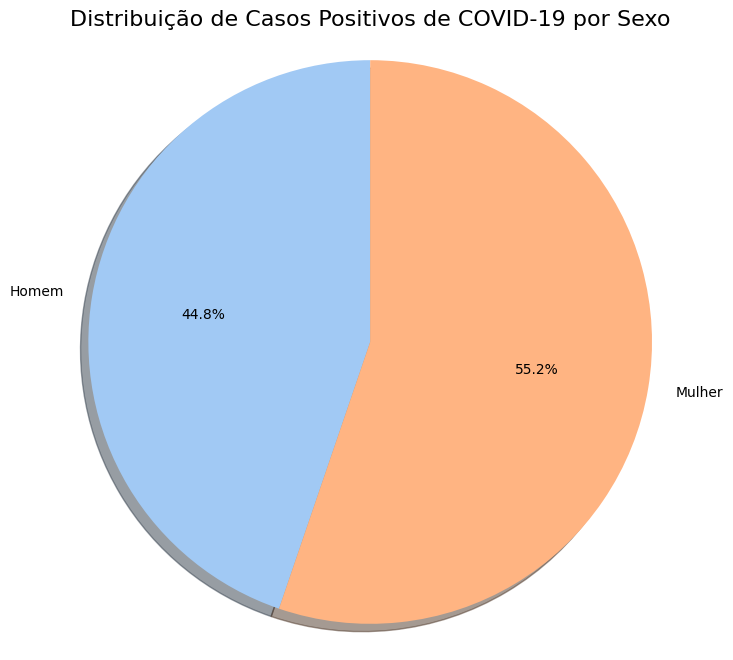

In [157]:
# Análise 4: Casos positivos por sexo
query4 = """
    SELECT
        dsm.PESS_SEXO_MORADOR_DESC AS Sexo,
        COUNT(dp.CTRL_ID) AS Total_Positivos
    FROM dados_pessoais dp
    JOIN dados_teste_covid dtc ON dp.CTRL_ID = dtc.CTRL_ID
    JOIN dic_sexo_morador dsm ON dp.PESS_SEXO_MORADOR = dsm.PESS_SEXO_MORADOR
    WHERE
        (dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1)
        AND dsm.PESS_SEXO_MORADOR_DESC IS NOT NULL
    GROUP BY
        dsm.PESS_SEXO_MORADOR_DESC
"""
analise4_df = spark.sql(query4)
print("Resultado da Análise 4:")
analise4_df.show()


pandas_df_4 = analise4_df.toPandas()


labels = pandas_df_4['Sexo']
sizes = pandas_df_4['Total_Positivos']
colors = sns.color_palette('pastel')[0:len(labels)] 


plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)


plt.title('Distribuição de Casos Positivos de COVID-19 por Sexo', fontsize=16)
plt.axis('equal')  


plt.savefig('grafico_casos_por_sexo.png', dpi=300)


plt.show()

# --- Fim do código de plotagem ---

### 5 - Estudantes ?

Resultado da Análise 5:
+---------------+---------------+
|Condicao_Estudo|Total_Positivos|
+---------------+---------------+
|            Não|           9385|
|            Sim|           8466|
+---------------+---------------+

Gráfico da Análise 5 salvo.


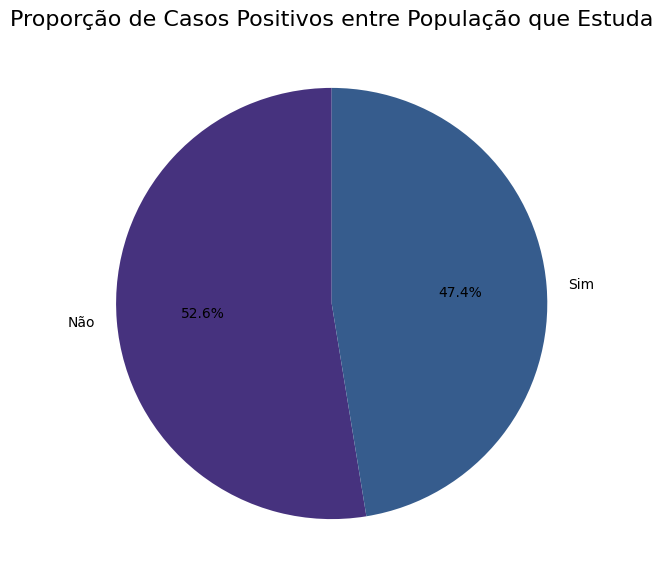

In [158]:
# Análise 5: Casos positivos entre pessoas que estudam
query5 = """
    SELECT
        de.ESTUDA_DESC AS Condicao_Estudo,
        COUNT(dp.CTRL_ID) AS Total_Positivos
    FROM dados_pessoais dp
    JOIN dados_teste_covid dtc ON dp.CTRL_ID = dtc.CTRL_ID
    JOIN dic_estuda de ON dp.PESS_ESTUDA = de.ESTUDA_COD
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY
        de.ESTUDA_DESC
"""
analise5_df = spark.sql(query5)
print("Resultado da Análise 5:")
analise5_df.show()

analise5_pd = analise5_df.toPandas()


plt.figure(figsize=(10, 7))
plt.pie(analise5_pd['Total_Positivos'],
        labels=analise5_pd['Condicao_Estudo'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis'))
plt.title('Proporção de Casos Positivos entre População que Estuda', fontsize=16)
plt.ylabel('') 

plt.savefig('05_positivos_entre_estudantes.png', dpi=300)

print("Gráfico da Análise 5 salvo.")


plt.show()

### 6 - Testes Positivos por tipo de Trabalho 

Resultado da Análise 6:
+-----------------------------------------------------------------------------------+---------------+
|Tipo_Trabalho                                                                      |Total_Positivos|
+-----------------------------------------------------------------------------------+---------------+
|Outros                                                                             |4670           |
|Técnico, profissional da saúde de nível médio                                      |2815           |
|Outra profissão de nível superior (advogado, engenheiro, contador, jornalista etc.)|2748           |
|Médico, enfermeiro, profissionais de saúde de nível superior                       |2424           |
|Auxiliar de escritório, escriturário                                               |2206           |
|Diretor, gerente, cargo político ou comissionado                                   |2160           |
|Professor da educação infantil, de ensino fundamental, mé

C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\701558082.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Positivos', y='Tipo_Trabalho', data=analise6_pd, palette='crest')


Gráfico da Análise 6 salvo.


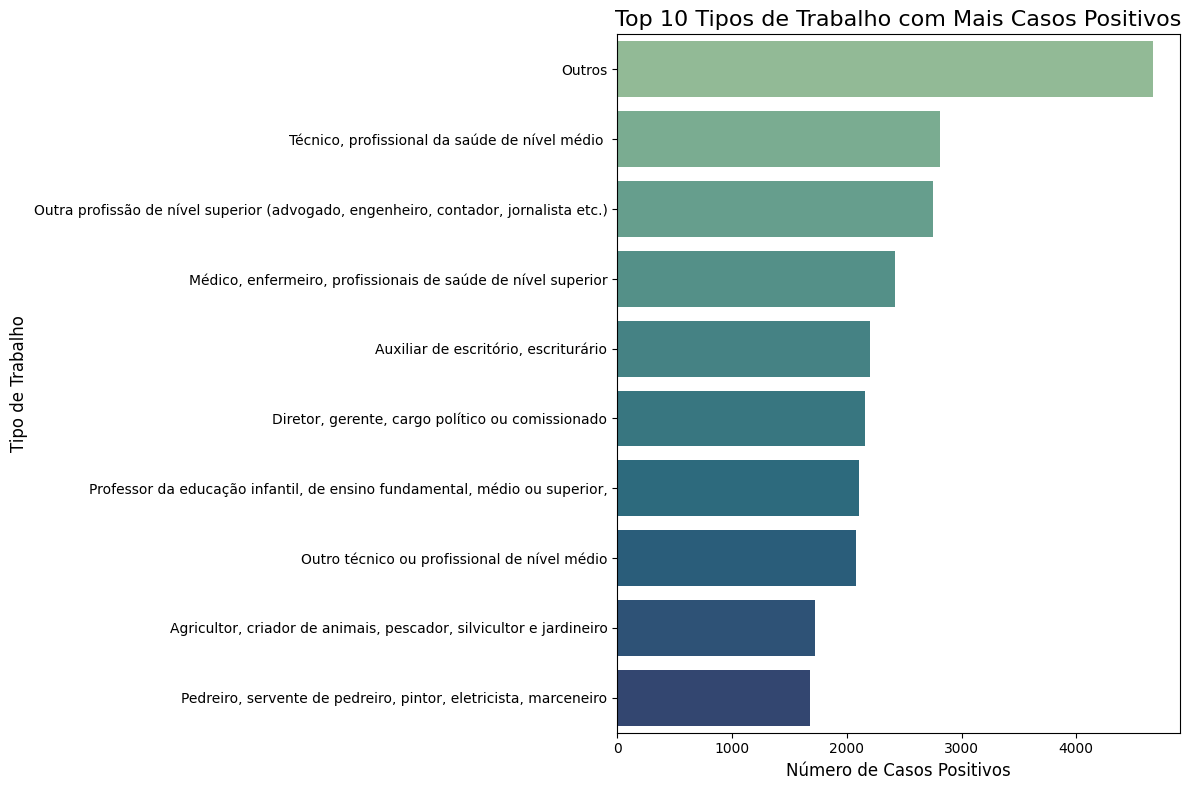

In [159]:
# Análise 6: Top 10 tipos de trabalho com mais casos positivos
query6 = """
    SELECT
        dtt.TRAB_TIPO_TRABALHO_DESC AS Tipo_Trabalho,
        COUNT(dt.CTRL_ID) AS Total_Positivos
    FROM dados_trabalho dt
    JOIN dados_teste_covid dtc ON dt.CTRL_ID = dtc.CTRL_ID
    JOIN dic_trab_tipo_trabalho dtt ON dt.TRAB_TIPO_TRABALHO = dtt.TRAB_TIPO_TRABALHO_COD
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY
        dtt.TRAB_TIPO_TRABALHO_DESC
    ORDER BY
        Total_Positivos DESC
    LIMIT 10
"""
analise6_df = spark.sql(query6)
print("Resultado da Análise 6:")
analise6_df.show(truncate=False)



analise6_pd = analise6_df.toPandas()


plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Positivos', y='Tipo_Trabalho', data=analise6_pd, palette='crest')


plt.title('Top 10 Tipos de Trabalho com Mais Casos Positivos', fontsize=16)
plt.xlabel('Número de Casos Positivos', fontsize=12)
plt.ylabel('Tipo de Trabalho', fontsize=12)


plt.tight_layout()


plt.savefig('06_positivos_por_tipo_trabalho.png', dpi=300)

print("Gráfico da Análise 6 salvo.")


plt.show()

### 7 -sintomas mais apresentados ?

Resultado da Análise 7:
+-------------+-----+-----+--------------------+------+------+--------------------+
|Dor_de_Cabeca|Febre|Tosse|Dificuldade_Respirar|Coriza|Fadiga|Perda_Olfato_Paladar|
+-------------+-----+-----+--------------------+------+------+--------------------+
|         5839| 4674| 4904|                2861|  3819|  4085|                4205|
+-------------+-----+-----+--------------------+------+------+--------------------+



C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\2817782035.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sintoma', y='Total_Ocorrencias', data=analise7_pd, palette='plasma')


Gráfico da Análise 7 salvo.


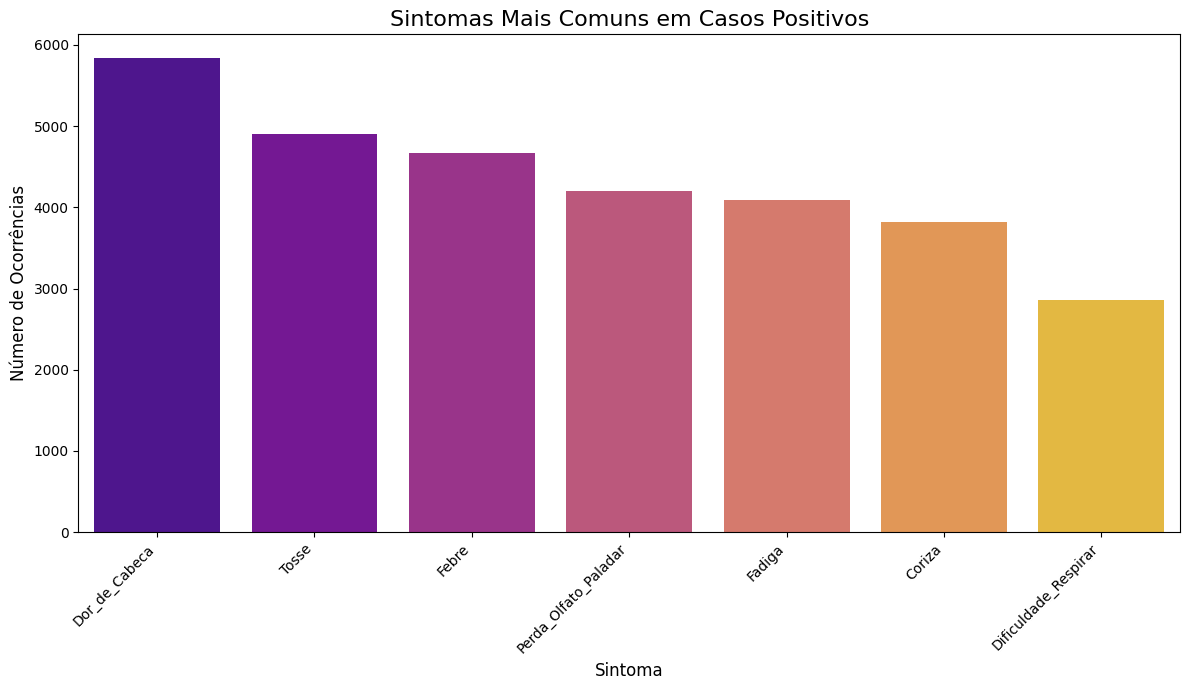

In [160]:
# Análise 7: Sintomas mais comuns entre os casos positivos
query7 = """
    SELECT
        SUM(CASE WHEN ds.SINT_DOR_CABECA = 1 THEN 1 ELSE 0 END) AS Dor_de_Cabeca,
        SUM(CASE WHEN ds.SINT_FEBRE = 1 THEN 1 ELSE 0 END) AS Febre,
        SUM(CASE WHEN ds.SINT_TOSSE = 1 THEN 1 ELSE 0 END) AS Tosse,
        SUM(CASE WHEN ds.SINT_DIF_RESPIRAR = 1 THEN 1 ELSE 0 END) AS Dificuldade_Respirar,
        SUM(CASE WHEN ds.SINT_CORIZA = 1 THEN 1 ELSE 0 END) AS Coriza,
        SUM(CASE WHEN ds.SINT_FADIGA = 1 THEN 1 ELSE 0 END) AS Fadiga,
        SUM(CASE WHEN ds.SINT_PERDA_OLFATO = 1 THEN 1 ELSE 0 END) AS Perda_Olfato_Paladar
    FROM dados_sintomas ds
    JOIN dados_teste_covid dtc ON ds.CTRL_ID = dtc.CTRL_ID
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
"""
analise7_df = spark.sql(query7)
print("Resultado da Análise 7:")
analise7_df.show()


analise7_pd = analise7_df.toPandas().transpose().reset_index()
analise7_pd.columns = ['Sintoma', 'Total_Ocorrencias']
analise7_pd = analise7_pd.sort_values('Total_Ocorrencias', ascending=False)


plt.figure(figsize=(12, 7))
sns.barplot(x='Sintoma', y='Total_Ocorrencias', data=analise7_pd, palette='plasma')
plt.title('Sintomas Mais Comuns em Casos Positivos', fontsize=16)
plt.xlabel('Sintoma', fontsize=12)
plt.ylabel('Número de Ocorrências', fontsize=12)
plt.xticks(rotation=45, ha='right')


plt.tight_layout()


plt.savefig('07_sintomas_mais_comuns.png', dpi=300)

print("Gráfico da Análise 7 salvo.")


plt.show()



### 8 - Assintomáticos positivos?

Resultado da Análise 8:
+-------------+-----------+
|     Condicao|Total_Casos|
+-------------+-----------+
|  Sintomático|       9486|
|Assintomático|      64848|
+-------------+-----------+

Gráfico da Análise 8 salvo.


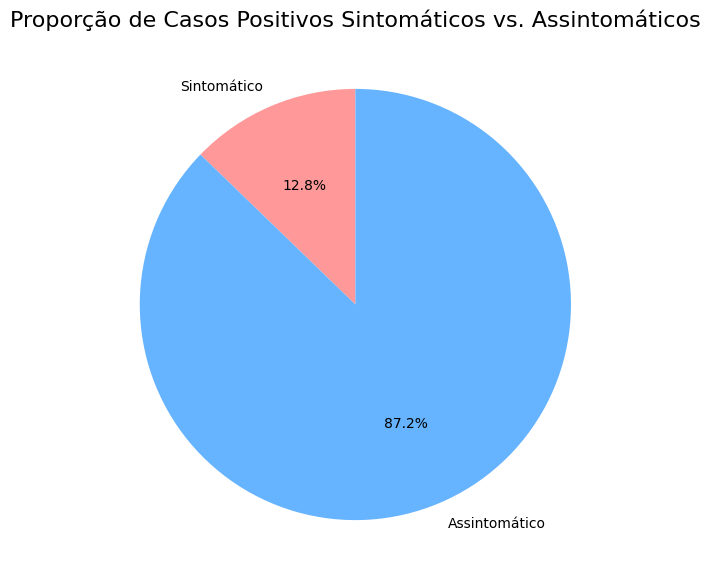

In [161]:
# Análise 8: Proporção de casos positivos sintomáticos vs. assintomáticos
query8 = """
    SELECT
        CASE
            WHEN SINT_FEBRE = 1 OR SINT_TOSSE = 1 OR SINT_DOR_CABECA = 1 OR SINT_DIF_RESPIRAR = 1 OR SINT_CORIZA = 1 OR SINT_FADIGA = 1 OR SINT_PERDA_OLFATO = 1 THEN 'Sintomático'
            ELSE 'Assintomático'
        END AS Condicao,
        COUNT(ds.CTRL_ID) as Total_Casos
    FROM dados_sintomas ds
    JOIN dados_teste_covid dtc ON ds.CTRL_ID = dtc.CTRL_ID
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY Condicao
"""
analise8_df = spark.sql(query8)
print("Resultado da Análise 8:")
analise8_df.show()


analise8_pd = analise8_df.toPandas()


plt.figure(figsize=(10, 7))
plt.pie(analise8_pd['Total_Casos'],
        labels=analise8_pd['Condicao'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff'])
plt.title('Proporção de Casos Positivos Sintomáticos vs. Assintomáticos', fontsize=16)
plt.ylabel('') 


plt.savefig('08_proporcao_assintomaticos.png', dpi=300)

print("Gráfico da Análise 8 salvo.")


plt.show()



### 9 Pessoas que praticaram Distanciamento Social para pessoas com SINTOMÁTICOS

Resultado da Análise 9:
+--------------------------------------------------------------------------------------------------------------------------------+-------------+-----------+
|Nivel_Distanciamento                                                                                                            |Condicao     |Total_Casos|
+--------------------------------------------------------------------------------------------------------------------------------+-------------+-----------+
|Ficou em casa e só saiu em caso de necessidade básica                                                                           |Assintomático|60642      |
|Ficou em casa e só saiu em caso de necessidade básica                                                                           |Sintomático  |9350       |
|Ficou rigorosamente em casa                                                                                                     |Assintomático|22859      |
|Ficou rigorosamente em casa      

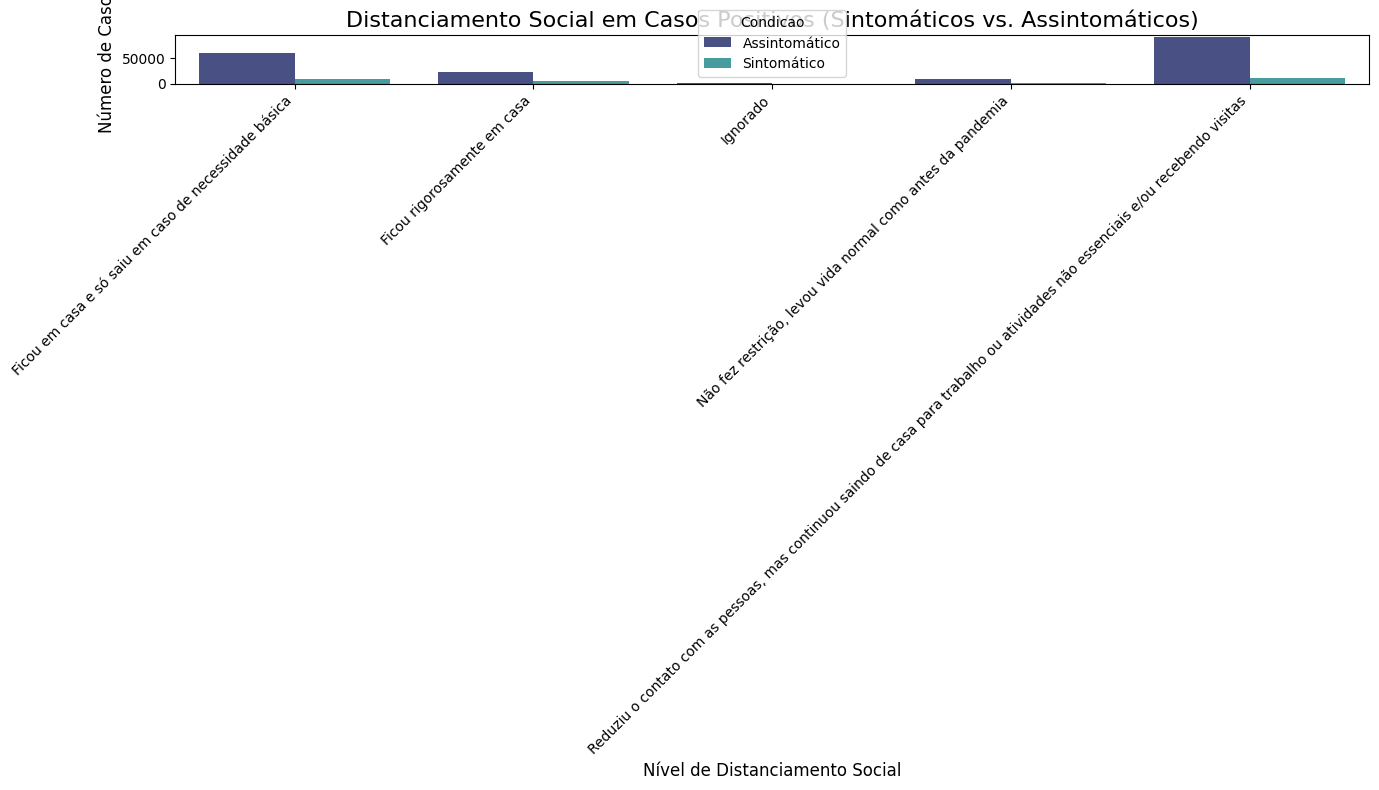

In [162]:
# Análise 9: Nível de distanciamento social para casos positivos, separado por sintomáticos e assintomáticos
query9 = """
    SELECT
        di.ISO_DESC AS Nivel_Distanciamento,
        CASE
            WHEN SINT_FEBRE = 1 OR SINT_TOSSE = 1 OR SINT_DOR_CABECA = 1 OR SINT_DIF_RESPIRAR = 1 OR SINT_CORIZA = 1 OR SINT_FADIGA = 1 OR SINT_PERDA_OLFATO = 1 THEN 'Sintomático'
            ELSE 'Assintomático'
        END AS Condicao,
        COUNT(dis.CTRL_ID) as Total_Casos
    FROM dados_isolamento_social dis
    JOIN dados_sintomas ds ON dis.CTRL_ID = ds.CTRL_ID
    JOIN dados_teste_covid dtc ON dis.CTRL_ID = dtc.CTRL_ID
    JOIN dic_isolamento_social di ON dis.DISTANC_SOCIAL = di.ISO_COD
    WHERE
        (dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1)
        AND di.ISO_DESC IS NOT NULL
    GROUP BY Nivel_Distanciamento, Condicao
    ORDER BY Nivel_Distanciamento, Condicao
"""
analise9_df = spark.sql(query9)
print("Resultado da Análise 9:")
analise9_df.show(truncate=False)


analise9_pd = analise9_df.toPandas()


plt.figure(figsize=(14, 8))
sns.barplot(x='Nivel_Distanciamento', y='Total_Casos', hue='Condicao', data=analise9_pd, palette='mako')
plt.title('Distanciamento Social em Casos Positivos (Sintomáticos vs. Assintomáticos)', fontsize=16)
plt.xlabel('Nível de Distanciamento Social', fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)
plt.xticks(rotation=45, ha='right')


plt.tight_layout()


plt.savefig('09_distanciamento_sintomaticos_vs_assintomaticos.png', dpi=300)

print("Gráfico da Análise 9 salvo.")


plt.show()



### 10 Casos Positivos por Situação que  Trabalha

Resultado da Análise 10:
+-----------------+---------------+
|Situacao_Trabalho|Total_Positivos|
+-----------------+---------------+
|              Não|          32381|
|              Sim|          38143|
+-----------------+---------------+

Gráfico da Análise 10 salvo.


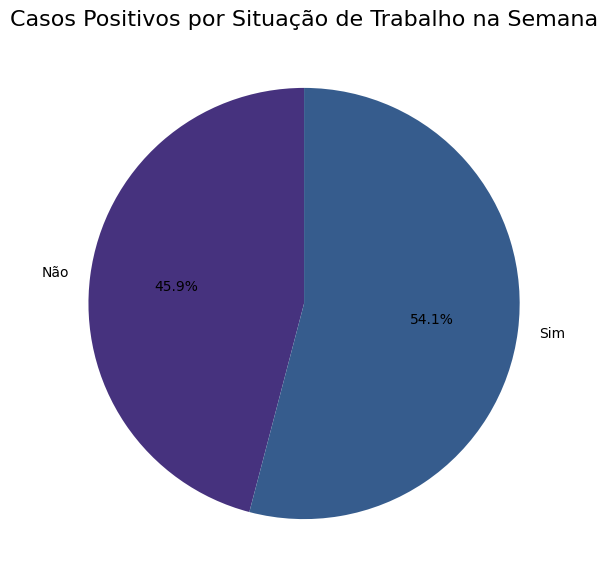

In [163]:
# Análise 10: Casos positivos por situação de trabalho na semana de referência
query10 = """
    SELECT
        dst.TRAB_SP_TRABALHOU_DESC AS Situacao_Trabalho,
        COUNT(dt.CTRL_ID) AS Total_Positivos
    FROM dados_trabalho dt
    JOIN dados_teste_covid dtc ON dt.CTRL_ID = dtc.CTRL_ID
    JOIN dic_trab_sp_trabalhou dst ON dt.TRAB_SP_TRABALHOU = dst.TRAB_SP_TRABALHOU_COD
    WHERE
        (dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1)
        AND dst.TRAB_SP_TRABALHOU_DESC IS NOT NULL
    GROUP BY
        dst.TRAB_SP_TRABALHOU_DESC
"""
analise10_df = spark.sql(query10)
print("Resultado da Análise 10:")
analise10_df.show()


analise10_pd = analise10_df.toPandas()


plt.figure(figsize=(10, 7))
plt.pie(analise10_pd['Total_Positivos'],
        labels=analise10_pd['Situacao_Trabalho'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis'))
plt.title('Casos Positivos por Situação de Trabalho na Semana', fontsize=16)
plt.ylabel('') 


plt.savefig('10_positivos_por_situacao_trabalho.png', dpi=300)

print("Gráfico da Análise 10 salvo.")


plt.show()



### 11 - Qual teste mais feito por todos

Resultado da Análise 11:
+-------------+---------------+
|   Tipo_Teste|Total_Realizado|
+-------------+---------------+
|         SWAB|          41781|
|Sangue (Dedo)|          53633|
|Sangue (Veia)|          32954|
+-------------+---------------+



C:\Users\Igor\AppData\Local\Temp\ipykernel_20228\3117486597.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tipo_Teste', y='Total_Realizado', data=analise11_pd, palette='magma')


Gráfico da Análise 11 salvo.


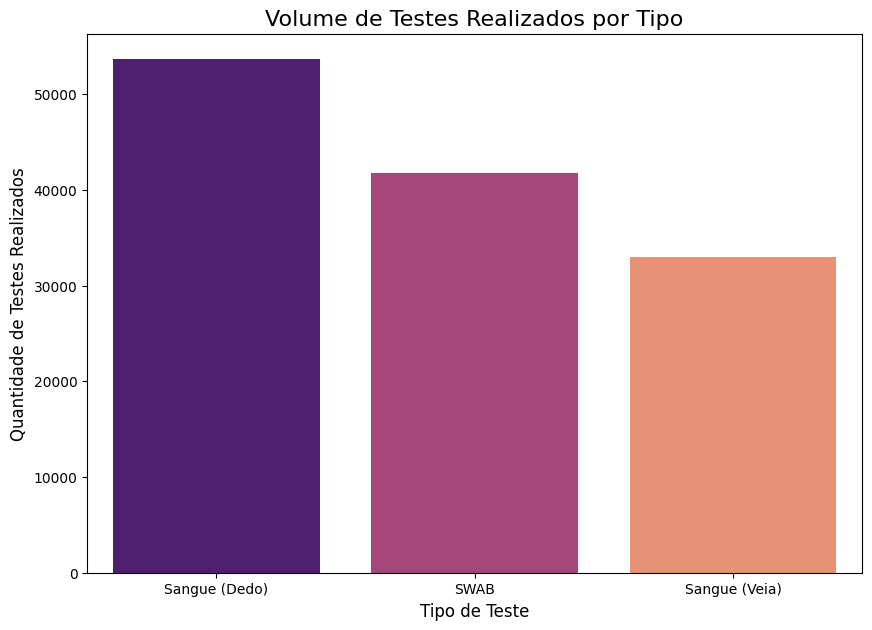

In [164]:
# Análise 11: Total de cada tipo de teste realizado
query11 = """
    SELECT 'SWAB' as Tipo_Teste, COUNT(TESTE_SWAB) as Total_Realizado FROM dados_teste_covid WHERE TESTE_SWAB IS NOT NULL
    UNION ALL
    SELECT 'Sangue (Dedo)' as Tipo_Teste, COUNT(TESTE_SANGUE_DEDO) as Total_Realizado FROM dados_teste_covid WHERE TESTE_SANGUE_DEDO IS NOT NULL
    UNION ALL
    SELECT 'Sangue (Veia)' as Tipo_Teste, COUNT(TESTE_SANGUE_VEIA) as Total_Realizado FROM dados_teste_covid WHERE TESTE_SANGUE_VEIA IS NOT NULL
"""
analise11_df = spark.sql(query11)
print("Resultado da Análise 11:")
analise11_df.show()


analise11_pd = analise11_df.toPandas().sort_values('Total_Realizado', ascending=False)


plt.figure(figsize=(10, 7))
sns.barplot(x='Tipo_Teste', y='Total_Realizado', data=analise11_pd, palette='magma')
plt.title('Volume de Testes Realizados por Tipo', fontsize=16)
plt.xlabel('Tipo de Teste', fontsize=12)
plt.ylabel('Quantidade de Testes Realizados', fontsize=12)


plt.savefig('11_testes_mais_realizados.png', dpi=300)

print("Gráfico da Análise 11 salvo.")


plt.show()



### 12 - Casos Positivos: Faixa Etária vs. Tipo de Ocupação

Resultado da Análise 12:
+------------+-----------------------------------------------------------------------------------+---------------+
|Faixa_Etaria|Ocupacao                                                                           |Total_Positivos|
+------------+-----------------------------------------------------------------------------------+---------------+
|0-17 Anos   |Médico, enfermeiro, profissionais de saúde de nível superior                       |12             |
|0-17 Anos   |Outra profissão de nível superior (advogado, engenheiro, contador, jornalista etc.)|2              |
|0-17 Anos   |Outros                                                                             |126            |
|0-17 Anos   |Técnico, profissional da saúde de nível médio                                      |7              |
|18-29 Anos  |Médico, enfermeiro, profissionais de saúde de nível superior                       |1305           |
|18-29 Anos  |Outra profissão de nível superior (advoga

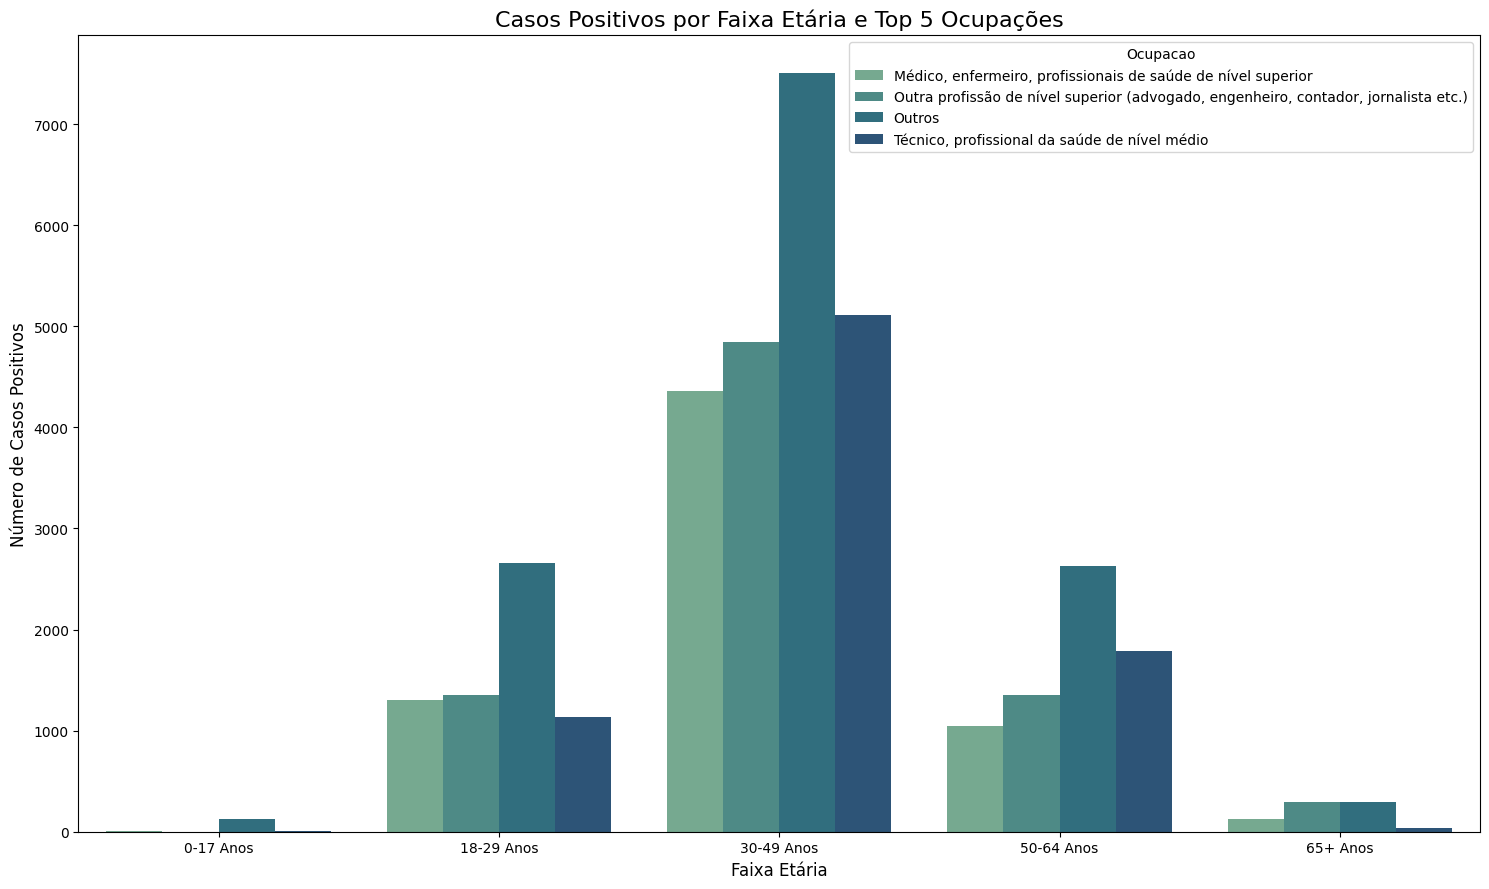

In [165]:
# Análise 12: Cruzamento de casos positivos por faixa etária e as 5 principais ocupações
query12 = """
    WITH TopOcupacoes AS (
        SELECT TRAB_TIPO_TRABALHO
        FROM dados_trabalho dt
        JOIN dados_teste_covid dtc ON dt.CTRL_ID = dtc.CTRL_ID
        WHERE dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
        GROUP BY TRAB_TIPO_TRABALHO
        ORDER BY COUNT(*) DESC
        LIMIT 5
    )
    SELECT
        CASE
            WHEN dp.PESS_IDADE_MORADOR <= 17 THEN '0-17 Anos'
            WHEN dp.PESS_IDADE_MORADOR BETWEEN 18 AND 29 THEN '18-29 Anos'
            WHEN dp.PESS_IDADE_MORADOR BETWEEN 30 AND 49 THEN '30-49 Anos'
            WHEN dp.PESS_IDADE_MORADOR BETWEEN 50 AND 64 THEN '50-64 Anos'
            ELSE '65+ Anos'
        END AS Faixa_Etaria,
        dtt.TRAB_TIPO_TRABALHO_DESC AS Ocupacao,
        COUNT(*) as Total_Positivos
    FROM dados_pessoais dp
    JOIN dados_trabalho dt ON dp.CTRL_ID = dt.CTRL_ID
    JOIN dados_teste_covid dtc ON dp.CTRL_ID = dtc.CTRL_ID
    JOIN dic_trab_tipo_trabalho dtt ON dt.TRAB_TIPO_TRABALHO = dtt.TRAB_TIPO_TRABALHO_COD
    WHERE (dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1)
      AND dt.TRAB_TIPO_TRABALHO IN (SELECT TRAB_TIPO_TRABALHO FROM TopOcupacoes)
    GROUP BY Faixa_Etaria, Ocupacao
    ORDER BY Faixa_Etaria, Ocupacao
"""
analise12_df = spark.sql(query12)
print("Resultado da Análise 12:")
analise12_df.show(truncate=False)


analise12_pd = analise12_df.toPandas()


plt.figure(figsize=(15, 9))
sns.barplot(data=analise12_pd, x="Faixa_Etaria", y="Total_Positivos", hue="Ocupacao", palette="crest")
plt.title("Casos Positivos por Faixa Etária e Top 5 Ocupações", fontsize=16)
plt.xlabel("Faixa Etária", fontsize=12)
plt.ylabel("Número de Casos Positivos", fontsize=12)
plt.xticks(rotation=0)


plt.tight_layout()


plt.savefig('12_positivos_faixa_etaria_vs_ocupacao.png', dpi=300)

print("Gráfico da Análise 12 salvo.")


plt.show()



### 13 - Proporção: Sintomáticos vs. Assintomáticos por idade

Resultado da Análise 13:
+------------+-------------+-----------+
|Faixa_Etaria|     Condicao|Total_Casos|
+------------+-------------+-----------+
|   0-17 Anos|Assintomático|      15275|
|   0-17 Anos|  Sintomático|       1656|
|  18-29 Anos|Assintomático|      32494|
|  18-29 Anos|  Sintomático|       4379|
|  30-49 Anos|Assintomático|      80165|
|  30-49 Anos|  Sintomático|      11862|
|  50-64 Anos|Assintomático|      39392|
|  50-64 Anos|  Sintomático|       5931|
|    65+ Anos|Assintomático|      16586|
|    65+ Anos|  Sintomático|       2904|
+------------+-------------+-----------+

Gráfico da Análise 13 salvo.


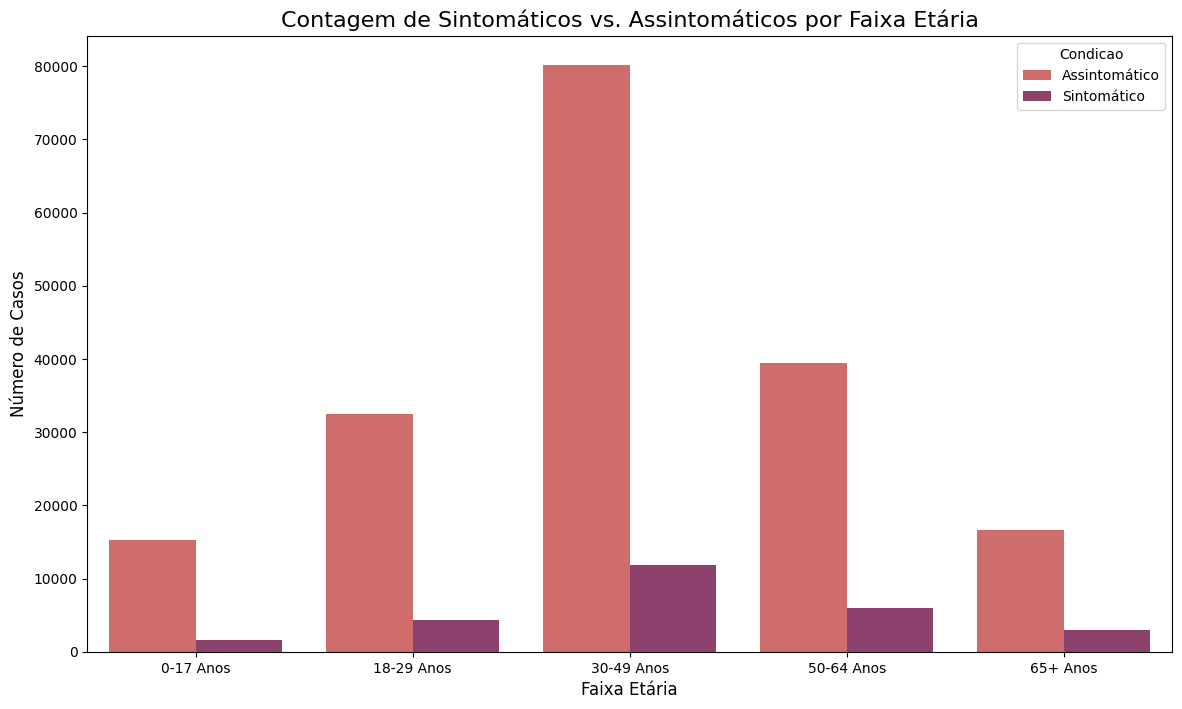

In [166]:
# Análise 13: Proporção de sintomáticos vs. assintomáticos por faixa etária
query13 = """
    SELECT
        CASE
            WHEN dp.PESS_IDADE_MORADOR <= 17 THEN '0-17 Anos'
            WHEN dp.PESS_IDADE_MORADOR BETWEEN 18 AND 29 THEN '18-29 Anos'
            WHEN dp.PESS_IDADE_MORADOR BETWEEN 30 AND 49 THEN '30-49 Anos'
            WHEN dp.PESS_IDADE_MORADOR BETWEEN 50 AND 64 THEN '50-64 Anos'
            ELSE '65+ Anos'
        END AS Faixa_Etaria,
        CASE
            WHEN SINT_FEBRE = 1 OR SINT_TOSSE = 1 OR SINT_DOR_CABECA = 1 OR SINT_DIF_RESPIRAR = 1 OR SINT_CORIZA = 1 OR SINT_FADIGA = 1 OR SINT_PERDA_OLFATO = 1 THEN 'Sintomático'
            ELSE 'Assintomático'
        END AS Condicao,
        COUNT(ds.CTRL_ID) as Total_Casos
    FROM dados_sintomas ds
    JOIN dados_pessoais dp ON ds.CTRL_ID = dp.CTRL_ID
    JOIN dados_teste_covid dtc ON ds.CTRL_ID = dtc.CTRL_ID
    WHERE
        dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1
    GROUP BY Faixa_Etaria, Condicao
    ORDER BY Faixa_Etaria, Condicao
"""
analise13_df = spark.sql(query13)
print("Resultado da Análise 13:")
analise13_df.show()




analise13_pd = analise13_df.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(data=analise13_pd, x="Faixa_Etaria", y="Total_Casos", hue="Condicao", palette="flare")
plt.title("Contagem de Sintomáticos vs. Assintomáticos por Faixa Etária", fontsize=16)
plt.xlabel("Faixa Etária", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)


plt.savefig('13_sintomaticos_vs_assintomaticos_por_idade.png', dpi=300)

print("Gráfico da Análise 13 salvo.")


plt.show()



### 14 - Casos Positivos por local de trabalho


Resultado da Análise 14:
+--------------------+---------------+
| Modalidade_Trabalho|Total_Positivos|
+--------------------+---------------+
|Presencial / Loca...|          33146|
|Remoto / Local Di...|           4644|
+--------------------+---------------+

Gráfico da Análise 14 salvo.


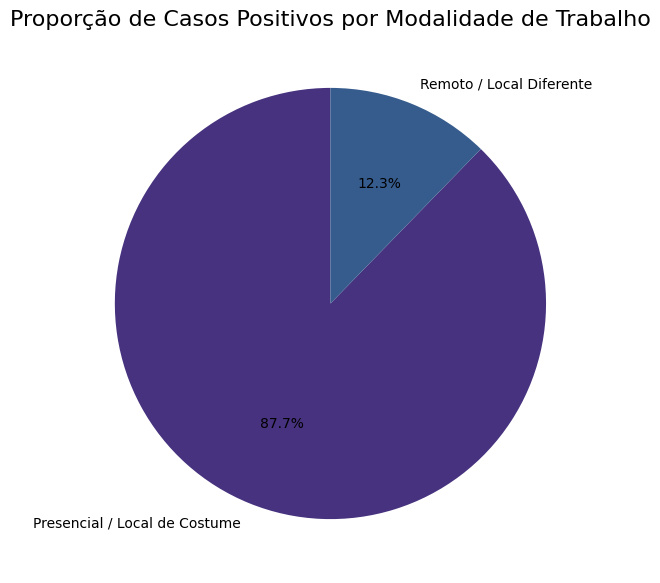

In [167]:
# Análise 14: Casos positivos por modalidade de trabalho (presencial/remoto)
query14 = """
    SELECT
        CASE
            WHEN dt.TRAB_PRESENCIAL = 1 THEN 'Presencial / Local de Costume'
            WHEN dt.TRAB_PRESENCIAL = 2 THEN 'Remoto / Local Diferente'
            ELSE 'Não Aplicável'
        END AS Modalidade_Trabalho,
        COUNT(dt.CTRL_ID) AS Total_Positivos
    FROM dados_trabalho dt
    JOIN dados_teste_covid dtc ON dt.CTRL_ID = dtc.CTRL_ID
    WHERE
        (dtc.TESTE_SWAB = 1 OR dtc.TESTE_SANGUE_DEDO = 1 OR dtc.TESTE_SANGUE_VEIA = 1)
        AND dt.TRAB_PRESENCIAL IS NOT NULL
    GROUP BY
        Modalidade_Trabalho
"""
analise14_df = spark.sql(query14)
print("Resultado da Análise 14:")
analise14_df.show()


analise14_pd = analise14_df.toPandas()


plt.figure(figsize=(10, 7))
plt.pie(analise14_pd['Total_Positivos'],
        labels=analise14_pd['Modalidade_Trabalho'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis'))
plt.title('Proporção de Casos Positivos por Modalidade de Trabalho', fontsize=16)
plt.ylabel('') 


plt.savefig('14_positivos_por_modalidade_trabalho.png', dpi=300)

print("Gráfico da Análise 14 salvo.")


plt.show()

